# Project Title
### Data Engineering Capstone Project

#### Project Summary
This project is focused on an extract, transform, and load (ETL) process that incorporates I94 immigration, demographic and temperature data of cities within the United States.  Raw data is staged, cleaned, and assembled into a data model for further analysis. 

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
    * I94 Immigration Data
    * US Cities Demographics
    * World Temperature Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

#### Do all imports and installs here

In [1]:
# Do all imports and installs here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pyspark.sql import SparkSession
import os
import glob
import configparser
from datetime import datetime, timedelta
from pyspark.sql import types as t
from pyspark.sql.functions import udf,to_date, date_add, col, monotonically_increasing_id
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear
import pyspark.sql.functions as f
import etl_functions

## Spark Session:

In [2]:
#The saurfang packages allow reading SAS binary file (.sas7bdat) in parallel as data frame in Spark SQL. 
spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Project Scope 
This project utilizes pandas software library and the Spark Python API (PySpark) to assemble raw data from three sources into a relational database which can easily be queried for analysis. Data is extracted from csv and sas files and staged within dataframes.  An analysis of each dataframe is performed to determine the structure, flaws, and characteristics of each dataframe.  A cleaning process resolves any identified flaws which may include missing values, duplicate rows, erroneous data etc.  
    
The dataframes are eventually  split into tables, compiling a data model used for ongoing data analysis. The data model was designed with a focus on US immigration and US city demographics and US temperatures.  Data for areas outside the US have been dropped during the cleaning process. End users are able to query the data to determine where immigration is focused and analyze those areas with regard to their historic temperatures and social demographics as of 2015. 

#### Describe and Gather Data 
* __I94 Immigration Data:__ This data comes from the US National Tourism and Trade Office. To enter the United States, all non-U.S. citizens from overseas countries traveling by air or sea must complete an I94 form.  The I94 forms are compiled into a database that provides a count of visitor arrivals to the United States (with stays of 1-night or more and visiting under certain visa types) to calculate U.S. travel and tourism volume exports.  
* __World Temperature Data:__ Originally compiled by the Berkeley Earth, which is affiliated with Lawrence Berkeley National Laboratory, this is a subset of a database that combines 1.6 billion temperature reports from 16 pre-existing archives.  The records start in 1750 for average land temperature and 1850 for max and min land temperatures and global ocean and land temperatures.
* __U.S. City Demographic Data:__ This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. The data comes from the US Census Bureau's 2015 American Community Survey.

### Gather Data

##### US Cities Demographics

In [3]:
# Read demographics data
#demographics_df = spark.read.format("csv").option("delimiter", ";").option("header", "true").load("us-cities-demographics.csv")
demographics_df = pd.read_csv("us-cities-demographics.csv", sep = ";")
demographics_df.shape

(2891, 12)

##### Immigration Data

In [4]:
# Read in the data here from sas file
immigration_df = spark.read.parquet("sas_data")
immigration_df.count(), len(immigration_df.columns)

(3096313, 28)

##### Temperature Data

In [5]:
# Read in the data here from csv file
#temperature_df = spark.read.csv('../../data2/GlobalLandTemperaturesByCity.csv',header = True, inferSchema = True)
temperature_df = pd.read_csv('../../data2/GlobalLandTemperaturesByCity.csv')
temperature_df.shape

(8599212, 7)

## Step 2: Explore and Assess the Data

#### Demographic Data Assessment

In [6]:
#Display sample of Demographic Data
demographics_df.sort_values("City",ascending=False).head(5)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
875,Yuma,Arizona,33.4,48298.0,45847.0,94145,7182.0,19326.0,2.64,AZ,White,69691
1084,Yuma,Arizona,33.4,48298.0,45847.0,94145,7182.0,19326.0,2.64,AZ,Hispanic or Latino,57054
2105,Yuma,Arizona,33.4,48298.0,45847.0,94145,7182.0,19326.0,2.64,AZ,Black or African-American,3731
1619,Yuma,Arizona,33.4,48298.0,45847.0,94145,7182.0,19326.0,2.64,AZ,Asian,1180
2859,Yuma,Arizona,33.4,48298.0,45847.0,94145,7182.0,19326.0,2.64,AZ,American Indian and Alaska Native,1228


In [7]:
#Display columns and data types of each
demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 12 columns):
City                      2891 non-null object
State                     2891 non-null object
Median Age                2891 non-null float64
Male Population           2888 non-null float64
Female Population         2888 non-null float64
Total Population          2891 non-null int64
Number of Veterans        2878 non-null float64
Foreign-born              2878 non-null float64
Average Household Size    2875 non-null float64
State Code                2891 non-null object
Race                      2891 non-null object
Count                     2891 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 271.1+ KB


In [8]:
#Display the number of rows and columns in demographics_df
demographics_df.shape

(2891, 12)

In [9]:
#Display the number of null values in each column of Demographic Data, it appears the data has relatively few null values
demographics_df.isnull().sum()

City                       0
State                      0
Median Age                 0
Male Population            3
Female Population          3
Total Population           0
Number of Veterans        13
Foreign-born              13
Average Household Size    16
State Code                 0
Race                       0
Count                      0
dtype: int64

In [10]:
#The number of unique City values is much smaller than the total number of rows indicating the City column contains many duplicates
demographics_df['City'].nunique()

567

In [11]:
#Create a new dataframe called cityStateDuplicate to display the number of times a city and state combination is duplicated. 
#It appears City values are duplicated up to 5 times. 
cityStateDuplicate = demographics_df.groupby(["City", "State"]).size().reset_index(name="Duplicate_Count")
cityStateDuplicate.sort_values("Duplicate_Count",ascending=False).head(5)

,City,State,Duplicate_Count
0,Abilene,Texas,5
392,Pasadena,Texas,5
386,Palm Coast,Florida,5
387,Palmdale,California,5
388,Palo Alto,California,5


In [12]:
#Using the 'Pasadena' and 'California' as an example combination, it appears City values are being duplicated to account for different Race values being split into separate rows.
demographics_df[(demographics_df.City == 'Pasadena') & (demographics_df.State == 'California')]

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
514,Pasadena,California,37.6,67712.0,74534.0,142246,4618.0,40779.0,2.63,CA,Hispanic or Latino,52717
1261,Pasadena,California,37.6,67712.0,74534.0,142246,4618.0,40779.0,2.63,CA,American Indian and Alaska Native,2161
1948,Pasadena,California,37.6,67712.0,74534.0,142246,4618.0,40779.0,2.63,CA,White,76525
2855,Pasadena,California,37.6,67712.0,74534.0,142246,4618.0,40779.0,2.63,CA,Black or African-American,15909
2856,Pasadena,California,37.6,67712.0,74534.0,142246,4618.0,40779.0,2.63,CA,Asian,22794


In [13]:
#Display the unique values found in the Race column
demographics_df.Race.unique()

array(['Hispanic or Latino', 'White', 'Asian', 'Black or African-American',
       'American Indian and Alaska Native'], dtype=object)

In [14]:
#It's clear Cities are being duplicated due to their number of unique races, to aid further analysis, the 'Duplicate_Count' column is renamed 'Unique_Races'.
cityStateDuplicate = cityStateDuplicate.rename(columns={'Duplicate_Count': 'Unique_Races'})

In [15]:
#Display the number of times a city, state and race combination is duplicated.  
#The result shows the Race value(eg. 'White', 'Asian' etc.) is not duplicated for any City and State combination, meaning each City and State combination has one row for each race value. 
cityStateRaceDuplicates = demographics_df.groupby(["City", "State","Race"]).size().reset_index(name="Duplicate_Count")
cityStateRaceDuplicates[(cityStateRaceDuplicates.Duplicate_Count > 1)].shape

(0, 4)

In [16]:
#Create new dataframe called demographics_df_WithRaceCount that includes the number of unique race values for each City State combination.
#The number of rows remains the same and one column has been added; the Duplicate_Count column.
demographics_df_WithRaceCount = demographics_df.merge(cityStateDuplicate, how = 'left', on = ['City', 'State'])
print(demographics_df_WithRaceCount.shape)
demographics_df_WithRaceCount.head(2)

(2891, 13)


,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count,Unique_Races
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924,5
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723,5


In [17]:
#Create spark Dataframe from demographics_df_WithRaceCount
spark_demographics_df_WithRaceCount = spark.createDataFrame(demographics_df_WithRaceCount)
#spark_demographics_df_WithRaceCount.createOrReplaceTempView('spark_demog')

In [18]:
#596 Rows of Unique City, State Combinations
len(demographics_df.groupby(["City", "State"]).nunique())

596

In [19]:
#Create new dataframe to pivot races into column headers.  This data frame has one row for each city and five columns, one for each race.
#The number of rows matches the original number of unique city, state combinations, confirming no cities were duplicated.
City_Race_Table = spark_demographics_df_WithRaceCount.groupBy(["City", "State"]).pivot('Race').sum('Count')
print(City_Race_Table.count(), len(City_Race_Table.columns))
City_Race_Table.show(5)

596 7
+--------------------+--------+---------------------------------+-----+-------------------------+------------------+------+
|                City|   State|American Indian and Alaska Native|Asian|Black or African-American|Hispanic or Latino| White|
+--------------------+--------+---------------------------------+-----+-------------------------+------------------+------+
|          Cincinnati|    Ohio|                             3362| 7633|                   133430|              9121|162245|
|           Lynchburg|Virginia|                             1024| 2910|                    23271|              2689| 53727|
|         Kansas City|  Kansas|                             2749| 7301|                    40177|             44342| 96113|
|Louisville/Jeffer...|Kentucky|                             4585|18601|                   151256|             28712|456451|
|              Dayton|    Ohio|                             2010| 1885|                    57280|              4945| 86016|
+-

In [20]:
#The number of unique Race values varies by City and appears to correlate with a city's total population.
#The table below groups the dataframe by Unique_Races(1-5) and provides the mean and count of rows in each Unique_Races category.
#This confirms the idea that higher numbers of Unique_Races exist in cities with higher populations
demographics_df_WithRaceCount.groupby('Unique_Races', as_index=False).agg({'Total Population': ['mean', 'count']})

Unique_Races Total Population      
                           mean count
0            1    145921.000000     2
1            2     89036.750000     8
2            3    103763.600000    30
3            4     82388.265306   196
4            5    209019.892655  2655

In [21]:
#the demographics_df_WithRaceCount dataframe is reduced to two columns to create a graph to better illustrate the table above. 
cityStateDuplicate_reduced = demographics_df_WithRaceCount[['Total Population', 'Unique_Races']].copy()
cityStateDuplicate_reduced.sort_values("Total Population",ascending=False).head(5)

,Total Population,Unique_Races
1826,8550405,5
2225,8550405,5
2493,8550405,5
2304,8550405,5
2494,8550405,5


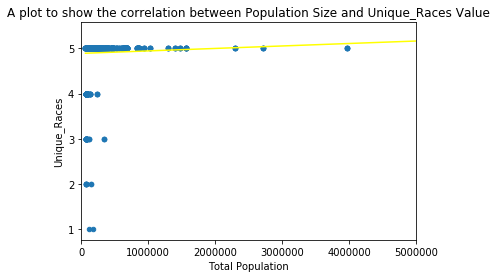

In [22]:
#The chart below further illustrates the coorilation between higher Unique_Races values and higher Total Population values.
demographics_df_WithRaceCount.plot(kind='scatter',y = "Unique_Races", x = "Total Population").set_xlim(0,5000000)
x = demographics_df_WithRaceCount["Total Population"]
y = demographics_df_WithRaceCount["Unique_Races"]
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='yellow')
plt.title('A plot to show the correlation between Population Size and Unique_Races Value')
plt.xlabel('Total Population')
plt.ylabel('Unique_Races')
plt.show()

In [23]:
demographics_df_WithRaceCount = etl_functions.add_raceCount_to_demographics(spark, demographics_df)
demographics_df_WithRaceCount.head()

Row(City='Cincinnati', State='Ohio', American Indian and Alaska Native=3362, Asian=7633, Black or African-American=133430, Hispanic or Latino=9121, White=162245)

### Immigration Data

_Column Name - Description_
* cicidUnique - record ID
* i94yr - 4 digit year
* i94mon - Numeric month
* i94cit - 3 digit code for immigrant country of birth
* i94res - 3 digit code for immigrant country of residence
* i94port - Port of admission 
* arrdate - Arrival Date in the USA
* i94mode - Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)
* i94addr - USA State of arrival
* depdate - Departure Date from the USA
* i94bir - Age of Respondent in Years
* i94visa - Visa codes collapsed into three categories
* count - Field used for summary statistics
* dtadfile - Character Date Field - Date added to I-94 Files
* visapost - Department of State where where Visa was issued
* occup - Occupation that will be performed in U.S
* entdepa - Arrival Flag - admitted or paroled into the U.S.
* entdepd - Departure Flag - Departed, lost I-94 or is deceased
* entdepu - Update Flag - Either apprehended, overstayed, adjusted to perm residence
* matflag - Match flag - Match of arrival and departure records
* biryear - 4 digit year of birth
* dtaddto - Character Date Field - Date to which admitted to U.S. (allowed to stay until)
* gender - Non-immigrant sex
* insnum - INSnumber 
* airline - Airline used to arrive in U.S.
* admnum - Admission Number
* fltno - Flight number of Airline used to arrive in U.S.
* visatype - Class of admission legally admitting the non-immigrant to temporarily stay in U.S.

In [24]:
#Display the shape of immigration_df
immigration_df.count(), len(immigration_df.columns)

(3096313, 28)

In [25]:
#Display the schema of immigration_df
immigration_df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [26]:
#Display the count of null and NaN values in each column
#Although some rows have a relatively high number of null or Nan values, they shouldn't impact final analysis, no null values will be dropped. 
from pyspark.sql.functions import isnan, isnull, when, count, col
nullValues = immigration_df.select([count(when(isnan(c) | isnull(c), c)).alias(c) for c in immigration_df.columns]).toPandas()
nullValues.rename(index={0: 'count'}).T.sort_values("count",ascending=False)


,count
entdepu,3095921
occup,3088187
insnum,2982605
visapost,1881250
gender,414269
i94addr,152592
depdate,142457
matflag,138429
entdepd,138429
airline,83627


In [27]:
#To verify the informaiton above, a duplicate query is perfomed on column i94addr
immigration_df.createOrReplaceTempView('ImmigrationTable')
spark.sql("SELECT count(*) from ImmigrationTable WHERE i94addr IS NULL").show()

+--------+
|count(1)|
+--------+
|  152592|
+--------+



In [28]:
#An attempt to drop rows that contain all missing values indicates none exist. 
immigration_df = immigration_df.na.drop("all")
immigration_df.count(), len(immigration_df.columns)

(3096313, 28)

In [29]:
immigration_df.createOrReplaceTempView('Immigration_Fact_Table')

In [30]:
#The 'arrdate' field indicates days since Jan. 1 1960 which is converted here to a usable date format and added to a new column titled 'arrival date'.
immigration_df = spark.sql("SELECT *, date_add(to_date('1960-01-01'), arrdate) AS arrival_date_1 FROM Immigration_Fact_Table")
immigration_df.head(1)

[Row(cicid=5748517.0, i94yr=2016.0, i94mon=4.0, i94cit=245.0, i94res=438.0, i94port='LOS', arrdate=20574.0, i94mode=1.0, i94addr='CA', depdate=20582.0, i94bir=40.0, i94visa=1.0, count=1.0, dtadfile='20160430', visapost='SYD', occup=None, entdepa='G', entdepd='O', entdepu=None, matflag='M', biryear=1976.0, dtaddto='10292016', gender='F', insnum=None, airline='QF', admnum=94953870030.0, fltno='00011', visatype='B1', arrival_date_1=datetime.date(2016, 4, 30))]

In [31]:
#Immigration_Fact_Table.shema, the new arrival_date_1 column is seen at the bottom of the schema.
immigration_df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

#### Temperature Data

In [32]:
#Display the columns and data types of temperature_df.  There are 8599212 rows and 7 columns.
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
dt                               object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                             object
Country                          object
Latitude                         object
Longitude                        object
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [33]:
#Convert the dt column to a date data type
temperature_df['dt'] = pd.to_datetime(temperature_df['dt'])

In [34]:
#Confirm the dt column is now data type datetime64
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
dt                               datetime64[ns]
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                             object
Country                          object
Latitude                         object
Longitude                        object
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 459.2+ MB


In [35]:
#Print number of times each county is duplicated, sort by descending order.
temperature_df.groupby('Country')['Country'].count().reset_index(name="Duplicate_Count").sort_values("Duplicate_Count",ascending=False).head(5)

,Country,Duplicate_Count
66,India,1014906
29,China,827802
151,United States,687289
18,Brazil,475580
119,Russia,461234


In [36]:
#We are only interested in rows with the Country column equal to 'United States'.  Filtering for 'United States' provides a data frame with 687289 rows, matching the previous function of counting duplicate Country values.
temperature_df = temperature_df[temperature_df['Country'] == 'United States']
#Print shape after removeing non-US Countries
temperature_df.shape

(687289, 7)

In [37]:
#List the sum of null values in each column
temperature_df.isnull().sum()

dt                                   0
AverageTemperature               25765
AverageTemperatureUncertainty    25765
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64

In [38]:
#Display a sample of the 25765 rows with null values in the AverageTemperature column
temperature_df[temperature_df.AverageTemperature.isnull()].head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
47723,1834-01-01,NaN,NaN,Abilene,United States,32.95N,100.53W
137067,1743-12-01,NaN,NaN,Akron,United States,40.99N,80.95W
137068,1744-01-01,NaN,NaN,Akron,United States,40.99N,80.95W
137069,1744-02-01,NaN,NaN,Akron,United States,40.99N,80.95W
137070,1744-03-01,NaN,NaN,Akron,United States,40.99N,80.95W


In [39]:
#Drop rows with null values in the AverageTemperature column.  Rerunning the function to display null value totals indicates there are no longer any null values found.
temperature_df = temperature_df.dropna(subset=['AverageTemperature'])
temperature_df.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

In [40]:
#Display the final size of the temperature_df dataframe.  
temperature_df.shape

(661524, 7)

In [41]:
#write to parquet
#temperature_df.write.parquet("sas_data")
#temperature_df=spark.read.parquet("sas_data")

#### Cleaning Steps

##### demographics_df
* Determine the number of unique race values exist for each City, State combination and add that value to new column called 'Unique_Races'
* Pivot the Race and Count values of each City, State combination into a new dataframe called 'City_Race_Table'

#### immigration_df
* Add a new column titled 'arrival_date' by converting values in column 'i94addr' from double type to data type date
* Add columns for port_of_entry_city and port_of_entry_state by joining the i94PortsOfEntryCodes sources from the I94 Immigration Data dictionary

#### temperature_df
* Convert the dt column to a date data type
* Drop where the Country column does not equal "United States"
* Drop rows containing a null value in the AverageTemperature column


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
The data model is composed of the fact table and dimension tables listed below.  Analysts are able to query information about US immigration patterns and demographic information about the cities where immigrants are arriving. The racial make up of US cities is found in a dedicated dimension table, allowing analysts to efficiently develope insights into a city's cultural make up without filtering duplicate rows of the city_demographics_dim table.  Immigration arrival times are also found in a dedicated table, allowing the user to efficiently filter for specific date parameters.

#### Fact Table:
_immigration_fact_

#### Dimension Tables:
* _immigration_arrival_time_dim_
* _city_demographics_dim_
* _city_races_dim_
* _temperature_dim_

Columns of each able listed below.


#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model
* Data sets are loaded from csv or sas files
* Each of the three data sets are cleaned and prepped for loading into final database tables
* Final data model tables are created using the cleaned data

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [42]:
portCode = pd.read_csv('i94PortsOfEntryCodes.csv')
portCode.head()


,code,location,state
0,ALC,ALCAN,AK
1,ANC,ANCHORAGE,AK
2,BAR,BAKER AAF - BAKER ISLAND,AK
3,DAC,DALTONS CACHE,AK
4,PIZ,DEW STATION PT LAY DEW,AK


### _immigration_fact_

In [43]:
immigration_df = etl_functions.add_arrivalDate_CityState_to_immigration_df(spark, immigration_df)
#Stage immigration data
immigration_df.createOrReplaceTempView('immigration_fact_table')

In [44]:
immigration_df.show(5)

+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+--------------+------------+------------------+-------------------+
|    cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|arrival_date_1|arrival_date|port_of_entry_city|port_of_entry_state|
+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+--------------+------------+------------------+-------------------+
|5748517.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     CA|20582.0|  40.0|    1.0|  1.0|20160430|     SYD| nu

In [45]:
immigration_df.count(), len(immigration_df.columns)

(3096313, 32)

In [46]:
immigration_fact = spark.sql("""
    SELECT
        cicid AS id, 
        i94yr AS year,
        i94mon AS numeric_month,
        i94cit AS birth_country,
        i94res AS residence_country,
        i94port AS admission_port,
        arrival_date,
        i94mode AS transportation_mode,
        i94addr AS arrival_state,
        depdate AS departure_date,
        i94bir AS age,
        i94visa AS visa_code,
        count AS count,
        dtadfile As date_added,
        visapost AS visa_post,
        occup AS occupation,
        entdepa AS arrival_flag,
        entdepd AS departure_flag,
        entdepu AS update_flag,
        matflag AS match_flag,
        biryear AS birth_year,
        dtaddto AS stay_date, 
        gender AS gender,
        insnum AS ins_number,
        airline AS airline,
        admnum AS admission_number,
        fltno AS flight_number,
        visatype AS visa_type,
        port_of_entry_city AS city,
        port_of_entry_state AS state
    FROM immigration_fact_table
""")

In [47]:
immigration_fact.createOrReplaceTempView('immigration_fact_table')

In [48]:
immigration_fact.show(5)

+---------+------+-------------+-------------+-----------------+--------------+------------+-------------------+-------------+--------------+----+---------+-----+----------+---------+----------+------------+--------------+-----------+----------+----------+---------+------+----------+-------+----------------+-------------+---------+-----------+-----+
|       id|  year|numeric_month|birth_country|residence_country|admission_port|arrival_date|transportation_mode|arrival_state|departure_date| age|visa_code|count|date_added|visa_post|occupation|arrival_flag|departure_flag|update_flag|match_flag|birth_year|stay_date|gender|ins_number|airline|admission_number|flight_number|visa_type|       city|state|
+---------+------+-------------+-------------+-----------------+--------------+------------+-------------------+-------------+--------------+----+---------+-----+----------+---------+----------+------------+--------------+-----------+----------+----------+---------+------+----------+-------+----

### _immigration_arrival_time_dim_

In [49]:
#Create immigration_arrival_time_dim dimension table
immigration_arrival_time_dim = spark.sql("""
    SELECT id, arrival_date, YEAR(arrival_date) as year,MONTH(arrival_date) as month,DAY(arrival_date) as day,WEEKOFYEAR(arrival_date) as week,DAYOFWEEK(arrival_date) as weekday,DAYOFYEAR(arrival_date) as day_of_year
    FROM immigration_fact_table
""")
                               

In [50]:
immigration_arrival_time_dim.show(5)

+---------+------------+----+-----+---+----+-------+-----------+
|       id|arrival_date|year|month|day|week|weekday|day_of_year|
+---------+------------+----+-----+---+----+-------+-----------+
|5748517.0|  2016-04-30|2016|    4| 30|  17|      7|        121|
|5748518.0|  2016-04-30|2016|    4| 30|  17|      7|        121|
|5748519.0|  2016-04-30|2016|    4| 30|  17|      7|        121|
|5748520.0|  2016-04-30|2016|    4| 30|  17|      7|        121|
|5748521.0|  2016-04-30|2016|    4| 30|  17|      7|        121|
+---------+------------+----+-----+---+----+-------+-----------+
only showing top 5 rows



### _city_demographics_dim_

In [51]:
demographics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 12 columns):
City                      2891 non-null object
State                     2891 non-null object
Median Age                2891 non-null float64
Male Population           2888 non-null float64
Female Population         2888 non-null float64
Total Population          2891 non-null int64
Number of Veterans        2878 non-null float64
Foreign-born              2878 non-null float64
Average Household Size    2875 non-null float64
State Code                2891 non-null object
Race                      2891 non-null object
Count                     2891 non-null int64
dtypes: float64(6), int64(2), object(4)
memory usage: 271.1+ KB


In [52]:
demographics_df_spark = spark.createDataFrame(demographics_df)
demographics_df_spark.createOrReplaceTempView("demographics_dim")

In [53]:
city_demographics_dim = spark.sql("""
    SELECT
        City,
        State,
        `Median Age` AS median_age,
        `Male Population` AS male_population,
        `Female Population` AS female_population,
        `Total Population` AS total_population,
        `Number of Veterans` AS number_of_veterans,
        `Foreign-born` AS foreign_born,
        `Average Household Size` AS average_household_size,
        `State Code` AS state_code
    FROM demographics_dim
""")

In [54]:
city_demographics_dim.show(5)

+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+
|            City|        State|median_age|male_population|female_population|total_population|number_of_veterans|foreign_born|average_household_size|state_code|
+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+
|   Silver Spring|     Maryland|      33.8|        40601.0|          41862.0|           82463|            1562.0|     30908.0|                   2.6|        MD|
|          Quincy|Massachusetts|      41.0|        44129.0|          49500.0|           93629|            4147.0|     32935.0|                  2.39|        MA|
|          Hoover|      Alabama|      38.5|        38040.0|          46799.0|           84839|            4819.0|      8229.0|                  2.58|        AL|
|Rancho Cucamonga|   California|  

### _temperature_dim_

In [55]:
cleaned_temperature_df = etl_functions.clean_temp_df(spark, temperature_df)

In [56]:
cleaned_temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661524 entries, 47555 to 8439246
Data columns (total 7 columns):
dt                               661524 non-null datetime64[ns]
AverageTemperature               661524 non-null float64
AverageTemperatureUncertainty    661524 non-null float64
City                             661524 non-null object
Country                          661524 non-null object
Latitude                         661524 non-null object
Longitude                        661524 non-null object
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 40.4+ MB


In [57]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661524 entries, 47555 to 8439246
Data columns (total 7 columns):
dt                               661524 non-null datetime64[ns]
AverageTemperature               661524 non-null float64
AverageTemperatureUncertainty    661524 non-null float64
City                             661524 non-null object
Country                          661524 non-null object
Latitude                         661524 non-null object
Longitude                        661524 non-null object
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 40.4+ MB


In [58]:
#Create a spark dataframe from the existing pandas dataframe
temperature_df_spark = spark.createDataFrame(cleaned_temperature_df)

In [59]:
temperature_df_spark.createOrReplaceTempView("temperature_dim")

In [60]:
temperature_dim = spark.sql("""
    SELECT
        dt AS Date,
        City AS City,
        Country AS Country,
        Latitude AS Latitude,
        AverageTemperatureUncertainty as AverageTemperatureUncertainty
    FROM temperature_Dim
""")

In [61]:
temperature_dim.show(5)

+-------------------+-------+-------------+--------+-----------------------------+
|               Date|   City|      Country|Latitude|AverageTemperatureUncertainty|
+-------------------+-------+-------------+--------+-----------------------------+
|1820-01-01 00:00:00|Abilene|United States|  32.95N|                        3.217|
|1820-02-01 00:00:00|Abilene|United States|  32.95N|                        2.853|
|1820-03-01 00:00:00|Abilene|United States|  32.95N|                        2.395|
|1820-04-01 00:00:00|Abilene|United States|  32.95N|                        2.202|
|1820-05-01 00:00:00|Abilene|United States|  32.95N|                        2.036|
+-------------------+-------+-------------+--------+-----------------------------+
only showing top 5 rows



### _city_races_dim_

In [62]:
city_races_function = etl_functions.add_raceCount_to_demographics(spark, demographics_df)
city_races_function.createOrReplaceTempView("city_races_function_spark")

In [63]:
city_races_dim = spark.sql("""
    SELECT 
        City AS City,
        State AS State,
        `American Indian and Alaska Native` AS American_Indian_and_Alaska_Native,
        Asian AS Asian,
        `Black or African-American` AS Black_or_African_American,
        `Hispanic or Latino` AS Hispanic_or_Latino,
        White AS White
    FROM city_races_function_spark

""")

In [64]:
city_races_dim.show(5)

+--------------------+--------+---------------------------------+-----+-------------------------+------------------+------+
|                City|   State|American_Indian_and_Alaska_Native|Asian|Black_or_African_American|Hispanic_or_Latino| White|
+--------------------+--------+---------------------------------+-----+-------------------------+------------------+------+
|          Cincinnati|    Ohio|                             3362| 7633|                   133430|              9121|162245|
|           Lynchburg|Virginia|                             1024| 2910|                    23271|              2689| 53727|
|         Kansas City|  Kansas|                             2749| 7301|                    40177|             44342| 96113|
|Louisville/Jeffer...|Kentucky|                             4585|18601|                   151256|             28712|456451|
|              Dayton|    Ohio|                             2010| 1885|                    57280|              4945| 86016|
+-------

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [65]:
def quality_check(df, df_name):
    row_count = df.count()
    if(row_count == 0):
        print(f"Data quality check failed for {df_name} table, zero rows found.")
    else:
        print(f"Data quality check passed for {df_name} table, {row_count} rows found.")

In [66]:
#Each table is processed by the quality_check function to confirm it contains content 
dataFrames = {
    'immigration fact':immigration_fact,
    'immigration arrival time dimension':immigration_arrival_time_dim,
    'city demographics dimension':city_demographics_dim,
    'temperature dimension':temperature_dim,
    'city races dimension':city_races_dim
}
for df_name, df in dataFrames.items():
    quality_check(df, df_name)

Data quality check passed for immigration fact table, 3096313 rows found.
Data quality check passed for immigration arrival time dimension table, 3096313 rows found.
Data quality check passed for city demographics dimension table, 2891 rows found.
Data quality check passed for temperature dimension table, 661524 rows found.
Data quality check passed for city races dimension table, 596 rows found.


In [67]:
city_demographics_dim.createOrReplaceTempView("city_demographics")
#The query below tests the illustrates the ability to join two tables in the data model using the state and city fields
quality_test_joined_table = spark.sql("""
    SELECT DISTINCT
    immigration_fact_table.id,
    immigration_fact_table.year,
    city_demographics.state_code,
    city_demographics.city,
    city_demographics.total_population
    FROM 
    immigration_fact_table 
    INNER JOIN city_demographics
    ON immigration_fact_table.state = city_demographics.state_code
    AND LOWER(immigration_fact_table.city) = LOWER(city_demographics.city)
""").show(10)

+---------+------+----------+--------+----------------+
|       id|  year|state_code|    city|total_population|
+---------+------+----------+--------+----------------+
|5926534.0|2016.0|        NY| Buffalo|          258066|
|6050833.0|2016.0|        NY| Buffalo|          258066|
|6058352.0|2016.0|        NY| Buffalo|          258066|
|5937309.0|2016.0|        NY| Buffalo|          258066|
|5918677.0|2016.0|        NY| Buffalo|          258066|
| 481083.0|2016.0|        OR|Portland|          632187|
| 499648.0|2016.0|        OR|Portland|          632187|
| 514502.0|2016.0|        OR|Portland|          632187|
| 691132.0|2016.0|        OR|Portland|          632187|
| 692462.0|2016.0|        OR|Portland|          632187|
+---------+------+----------+--------+----------------+
only showing top 10 rows



In [68]:
immigration_fact.createOrReplaceTempView('imm_fact')
city_demographics_dim.createOrReplaceTempView('city_dim')
temperature_dim.createOrReplaceTempView('temp_dim')
city_races_dim.createOrReplaceTempView('races_dim')
immigration_arrival_time_dim.createOrReplaceTempView('arrival_dim')

In [69]:
#This function counts the number of null values in the primary keys of each table and prints a message indicating if any are found or not.
def countNullValues(tables_keys, spark):
    for table, column in tables_keys.items():
        null_count = spark.sql(f"SELECT COUNT(*) FROM {table} WHERE {column[0]} IS NULL")
        if(null_count.head()[0] > 0):
            print(f"Data quality null values check failed for {table} table, {null_count} null rows found.")
        else:
            print(f"Data quality null values check passed for {table} table.")                            

In [70]:
tables_keys = {'imm_fact':['id'],'arrival_dim':['id'],'city_dim':['state'],'city_dim':['state_code'],'temp_dim':['date'],'races_dim':['state']}
countNullValues(tables_keys, spark)

Data quality null values check passed for imm_fact table.
Data quality null values check passed for arrival_dim table.
Data quality null values check passed for city_dim table.
Data quality null values check passed for temp_dim table.
Data quality null values check passed for races_dim table.


#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Fact Table
_immigration_fact_
_Column Name - Description_
* id - record ID
* year - 4 digit year
* numeric_month - Numeric month
* birth_country - 3 digit code for immigrant country of birth
* residence_country - 3 digit code for immigrant country of residence
* admission_port - Port of admission 
* arrival_date - Arrival Date in the USA
* transportation_mode - Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)
* arrival_state - USA State of arrival
* departure_date - Departure Date from the USA
* age - Age of Respondent in Years
* visa_code - Visa codes collapsed into three categories
* count - Field used for summary statistics
* date_added - Character Date Field - Date added to I-94 Files
* visa_post - Department of State where where Visa was issued
* occupation - Occupation that will be performed in U.S
* arrival_flag - Arrival Flag - admitted or paroled into the U.S.
* departure_flag - Departure Flag - Departed, lost I-94 or is deceased
* update_flag - Update Flag - Either apprehended, overstayed, adjusted to perm residence
* match_flag - Match flag - Match of arrival and departure records
* birth_year - 4 digit year of birth
* stay_date - Character Date Field - Date to which admitted to U.S. (allowed to stay until)
* gender - Non-immigrant sex
* ins_number - INSnumber 
* airline - Airline used to arrive in U.S.
* admission_number - Admission Number
* flight_number - Flight number of Airline used to arrive in U.S.
* visa_type - Class of admission legally admitting the non-immigrant to temporarily stay in U.S.
* City - City of entry
* State - State of entry

#### Dimension Tables:

##### _immigration_arrival_time_dim_
Arrival date of each immigration record is split into a more granular data set to allow an analyst to easily filter a query by a more specific date parameter.  The table can be joined on the id column.

* id - Unique record id 
* date - original arrival date from immigration_fact table
* year - original arrival year
* month - original arrival month
* day - original arrival day
* week - original arrival week
* weekday - original arrival weekday

##### _city_demographics_dim_
This table is composed of original US Census Bureau's 2015 American Community Survey. The Unique_Races column has been added to provide additional insight into a city's cultural make up.  The table can be joined on the city and state columns.
* city
* state
* median Age
* male Population
* female Population
* total Population
* number of Veterans
* foreign-born
* average Household Size
* state Code
* race
* count
* unique_races

##### _city_races_dim_
The types of races that are accounted for in each city included in the city_demographics_dim are pivoted into columns.  The table can be joined to other tables using the city and state columns.
* city
* ctate
* american Indian and Alaska Native
* asian
* black or African-American
* hispanic or Latino
* white

##### _temperature_dim_
Historic temperatures of cities within the United States are included.  The table can be joined to other tables using the city column.
* dt - date temperature was recorded
* averageTemperature
* averageTemperatureUncertainty
* city
* country
* latitude
* longitude



## Step 5: Complete Project Write Up

#### Rationale for the choice of tools and technologies used in this project

* This project utilized Sparkpy and the pandas python library to manipulate and organize data from three sources.  Sparkpy was uniquely valuable to the project due to its ability to process large amounts of data. Pandas was also very useful in efficiently evaluating and cleaning the raw data. Utilizing both tools within a Jupyter Notebook creates a very user-friendly environment where raw data is stage, explored, and eventually structure, all within a single interface.  Other users can see all steps taken to load and prepare data, allowing a transparent and clear understanding of the ETL process and scope of data available to all eventual users. 
* To accommodate a user's preference for the latest data, the data source files should be updated as new files are made available. Additional files can be appended to existing tables and processed per the existing ETL procedure. 

#### Alternative Scenarios

* If the amount of data was increased by 100x the ETL would need to rely more on Sparkpy and less on Pandas.  Several evaluation and cleaning functions would need to employ Sparkpy functions due to their ability to process large amounts of data.  Depending on an organization’s requirements, use of a cloud service such as AWS EMR may also be required to reduce the processing time by increasing the number of machines being used to process the data. 
* The ETL within this Jupyter Notebook can be executed on a scheduled basis using external plugins such as Apache Airflow or the Papermill library.  Doing so would allow automated workflows to populate databases on a schedule to accommodate an organization's data communication requirements such as dashboards, reports, and alerts. 
* To share the database with a wider user group, tools such as an Amazon S3 Bucket could be employed to store and provide user access across an organization.
